In [2]:
import pandas as pd
import plotly.express as px
from pymongo import MongoClient
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from utils import (
    extrapolated_multiitemp_lambdahat
)
import plotly.io as pio
from dln import (
    true_dln_learning_coefficient
)
import json
import os
from datetime import datetime

# Querying data from DB and parsing

In [1357]:

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['dln_lambdahat']
# db = client['dln_lambdahat_dev']
collection = db['runs']

# Query data
# EXPT_NAME = "dev"
# EXPT_NAME = "dev_hessian2"

# EXPT_NAME = "random_sv_20231213"
# EXPT_NAME = "batch500_width10-100_layer2-20_sv_202312130129"
# EXPT_NAME = "batch500_width10-100_layer2-10_sv_202312131012"
# EXPT_NAME = "batch500_width10-100_layer2-10_sv_202312131121"
# EXPT_NAME = "batch500_width2-10_layer5_sv_202312131342" # fix layer=5, vary widths 2-20
# EXPT_NAME = "batch500_width2-10_layer5_sv_202312131424" # fix widths=5, vary layer=2-20
# EXPT_NAME = "zerotruth_batch500_width10-100_layer2-20_sv_202312132339"

# EXPT_NAME = "randsv_batch500_width10-50_layer2-15_sv_202312141156"
# EXPT_NAME = "randsv_batch500_width10-50_layer2-15_sv_202312141203"

# EXPT_NAME = "randsv_batch500_width10-50_layer2-15_withtraining_202312150141"
# EXPT_NAME = "zero_batch500_width10-50_layer2-15_withtraining_202312150205"
# EXPT_NAME = "randrank_batch500_width10-50_layer2-15_withtraining_202401162253"
EXPT_NAME = "randrank_batch500_width10-50_layer2-15_withtraining_prank0.8_202401170119"
# EXPT_NAME = "randrank_batch500_width10-50_layer2-15_withtraining_prank0.2_202401170120"

# EXPT_NAME = "randsv_batch500_width2-5_layer2-5_notraining_202312152208"
# EXPT_NAME = "zero_batch500_width2-5_layer2-5_notraining_funcrank_202312152247"
# EXPT_NAME = "randsv_batch500_width2-5_layer2-5_notraining_funcrank_202312162227"
# EXPT_NAME = "randsv_batch500_width15_layer2-5_notraining_funcrank_202312162325"

# EXPT_NAME = "randrank_batch500_width5-20_layer3-15_notraining_funcrank_hesstrace_202312202339"
# EXPT_NAME = "randrank_batch500_width10-30_layer5_notraining_funcrank_hesstrace_202312210122"
# EXPT_NAME = "randrank_batch500_width10-30_layer5_notraining_funcrank_hesstrace_202312210949"
# EXPT_NAME = "zero_batch500_width5-20_layer3-15_notraining_funcrank_hesstrace_202312211849"
# EXPT_NAME = "zero_batch500_width5-20_layer5-15_notraining_funcrank_hesstrace_202312232347"
# EXPT_NAME = "random_batch500_width5-50_layer5-15_notraining_funcrank_hesstrace_202312230022"
# EXPT_NAME = "rankrank_batch500_width50-100_layer5-20_notraining_202401091346"

# EXPT_NAME = "zero_batch500_width5-50_layer5-15_notraining_funcrank_hesstrace_202312220314"
# EXPT_NAME = "random_batch500_width5-50_layer5-15_notraining_funcrank_hesstrace_202312220314"
# EXPT_NAME = "randrank_batch500_width5-10_layer2_notraining_funcrank_hesstrace_202312211353"

# EXPT_NAME = "rankrank_batch500_width100-800_layer5-10_notraining_202401142254"


query = {
    "config.expt_name": EXPT_NAME, 
    "status": "COMPLETED", 
}
projection = {
    "epsilon": "$config.sgld_config.epsilon", 
    "num_steps": "$config.sgld_config.num_steps",
    "input_dim": "$config.input_dim",
    "layer_widths": "$config.layer_widths",
    "num_training_data": "$config.num_training_data",
    "itemp": "$config.itemp",
    "lambdahat": "$info.lambdahat",
    "true_lambda": "$info.true_lambda",
    "true_rank": "$info.true_rank",
    "loss_trace": "$info.loss_trace",
    "init_loss": "$info.init_loss",
    "true_multiplicity": "$info.true_multiplicity",
    "lambdahat_trained": "$info.trained_param_info.lambdahat",
    "model_dim": "$info.model_dim",
    "functional_rank": "$info.functional_rank_info.functional_rank", 
    "hessian_trace_estimate": "$info.hessian_trace_estimate",
    "svdvals": "$info.functional_rank_info.singular_values"
}
sample_doc = collection.find_one(query)


# Create DataFrame
print("Creating dataframe...")
df_data = pd.DataFrame(list(collection.find(query, projection)))


Creating dataframe...


In [276]:
def extract_data(subdir):
    with open(os.path.join(subdir, 'config.json'), 'r') as f:
        config = json.load(f)

    with open(os.path.join(subdir, 'info.json'), 'r') as f:
        info = json.load(f)
    doc = {"config": config, "info": info}

    data = {
        "epsilon": config.get('sgld_config', {}).get('epsilon'),
        "num_steps": config.get('sgld_config', {}).get('num_steps'),
        "input_dim": config.get('input_dim'),
        "layer_widths": config.get('layer_widths'),
        "num_training_data": config.get('num_training_data'),
        "itemp": config.get('itemp'),
        "do_training": config.get("do_training"), 
        "lambdahat": info.get('lambdahat'),
        "true_lambda": info.get('true_lambda'),
        "true_rank": info.get('true_rank'),
        "loss_trace": info.get('loss_trace'),
        "init_loss": info.get('init_loss'),
        "true_multiplicity": info.get('true_multiplicity'),
        "lambdahat_trained": info.get('trained_param_info', {}).get('lambdahat'),
        "loss_trace_trained": info.get("trained_param_info", {}).get("loss_trace"),
        "init_loss_trained": info.get("trained_param_info", {}).get("init_loss"),
        "model_dim": info.get('model_dim'),
        "functional_rank": info.get('functional_rank_info', {}).get('functional_rank'),
        "hessian_trace_estimate": info.get('hessian_trace_estimate'),
        "svdvals": info.get('functional_rank_info', {}).get('singular_values'), 
        "mala_acceptance_probs": info.get("mala_acceptance_probs")
    }
    return data, doc

def extract_directory(directory_path):
    all_data = []
    doc = None
    for subdir in os.listdir(directory_path):
        full_subdir_path = os.path.join(directory_path, subdir)
        if subdir == "_sources" or not os.path.isdir(full_subdir_path):
            continue
        if set(["info.json", "config.json"]).issubset(set(os.listdir(full_subdir_path))):
            try: 
                data, doc = extract_data(full_subdir_path)
                data["_id"] = int(subdir)
                data["dirname"] = os.path.basename(directory_path)
                all_data.append(data)
            except:
                print("ERROR: ", full_subdir_path)
        else:
            print(f"No info.json or config.json: {full_subdir_path}")
    return all_data, doc



# directory_path = './spartan_outputs/202401191706'
# directory_path = './spartan_outputs/random_batch500_width500-1000_layer2-20_trainTrue_202401200314'
# directory_path = "./spartan_outputs/rand_rank_batch500_width500-1000_layer2-20_trainTrue_202401200311"
# directory_path = "./spartan_outputs/zero_batch500_width500-1000_layer2-20_trainTrue_202401201530"
# directory_path = "./spartan_outputs/random_batch500_width500-3000_layer2-20_trainFalse_202401210232"
# directory_path = "./spartan_outputs/rand_rank_batch500_width500-3000_layer2-20_trainFalse_202401210232"
# directory_path = "./spartan_outputs/zero_batch500_width500-3000_layer2-20_trainFalse_202401210233"

# directory_path = "./spartan_outputs/zero_batch500_width500-3000_layer2-20_trainFalse_202401211705"
# directory_path = "./spartan_outputs/random_batch500_width500-3000_layer2-20_trainFalse_202401211705"
# directory_path = "./spartan_outputs/rand_rank_batch500_width500-3000_layer2-20_trainFalse_202401211705"


# directory_path = "./spartan_outputs/rand_rank_batch1000_width50-300_layer2-20_trainFalse_n1000000_202401241838"
# directory_path = "./spartan_outputs/rand_rank_batch500_width500-3000_layer2-20_trainFalse_n100000_202401241557"
# directory_path = "./spartan_outputs/rand_rank_batch1000_width500-3000_layer2-20_trainFalse_n100000_202401241835"
# directory_path = "./spartan_outputs/rand_rank_batch1000_width50-300_layer2-20_trainFalse_n1000000_202401250022"
# directory_path = "./spartan_outputs/rand_rank_batch500_width50-300_layer2-20_trainFalse_n100000_202401250040"
# directory_path = "./spartan_outputs/rand_rank_batch1000_width500-3000_layer2-20_trainFalse_n100000_202401250035"
# directory_path = "./spartan_outputs/rand_rank_batch1000_width500-3000_layer2-10_trainFalse_n500000_202401250036"
# directory_path = "./spartan_outputs/rand_rank_batch500_width50-300_layer2-20_trainFalse_n1000000_202401250040"


# directory_path = "./spartan_outputs/rand_rank_batch500_width500-2000_layer2-20_trainFalse_n1000000_202401251620"
# directory_path = "./spartan_outputs/rand_rank_batch500_width50-300_layer2-20_trainFalse_n1000000_202401251540"
# directory_path = "./spartan_outputs/rand_rank_batch500_width500-2000_layer2-20_trainFalse_n500000_202401252345"
# directory_path = "./spartan_outputs/rand_rank_batch500_width100-1000_layer2-20_trainFalse_n1000000_202401261040"
# directory_path = "./spartan_outputs/rand_rank_batch500_width100-1000_layer2-20_trainFalse_n1000000_202401260003"
# directory_path = "./spartan_outputs/rand_rank_batch500_width100-1000_layer2-20_trainFalse_n1000000_202401261737"
# directory_path = "./spartan_outputs/rand_rank_batch500_width50-300_layer2-20_trainFalse_n1000000_202401261740"

# directory_path = "./spartan_outputs/zero_batch500_width50-300_layer2-20_trainFalse_n1000000_202401270024"
# directory_path = "./spartan_outputs/zero_batch500_width100-1000_layer2-20_trainFalse_n1000000_202401270027"
# directory_path = "./spartan_outputs/zero_batch500_width100-1000_layer2-20_trainFalse_n1000000_202401271744"

# directory_path = "./spartan_outputs/random_batch500_width50-300_layer2-20_trainFalse_n1000000_202401272350"
# directory_path = "./spartan_outputs/random_batch500_width100-1000_layer2-20_trainFalse_n1000000_202401272350"
# EXPT_NAME = os.path.split(directory_path)[1]

# all_data = []
# for subdir in os.listdir(directory_path):
#     full_subdir_path = os.path.join(directory_path, subdir)
#     if subdir == "_sources" or not os.path.isdir(full_subdir_path):
#         continue
#     if set(["info.json", "config.json"]).issubset(set(os.listdir(full_subdir_path))):
#         try: 
#             data, doc = extract_data(full_subdir_path)
#             data["_id"] = int(subdir)
#             all_data.append(data)
#             sample_doc = doc
#         except:
#             print("ERROR: ", full_subdir_path)

directory_paths = [
    # "./spartan_outputs/rand_rank_batch500_width500-2000_layer2-20_trainFalse_n500000_202401252345",
    # "./spartan_outputs/rand_rank_batch500_width100-1000_layer2-20_trainFalse_n1000000_202401261737",
    # "./spartan_outputs/rand_rank_batch500_width50-300_layer2-20_trainFalse_n1000000_202401261740",
    
    # "./spartan_outputs/zero_batch500_width50-300_layer2-20_trainFalse_n1000000_202401270024",
    # "./spartan_outputs/zero_batch500_width100-1000_layer2-20_trainFalse_n1000000_202401270027",
    # "./spartan_outputs/zero_batch500_width100-1000_layer2-20_trainFalse_n1000000_202401271744",

    # "./spartan_outputs/random_batch500_width50-300_layer2-20_trainFalse_n1000000_202401272350",
    # "./spartan_outputs/random_batch500_width100-1000_layer2-20_trainFalse_n1000000_202401272350",



    
    # "./spartan_outputs/rand_rank_batch500_width50-300_layer2-20_trainTrue_n1000000_eps1e-07_nstep50000_202401281612", 
    # "./spartan_outputs/rand_rank_batch500_width100-1000_layer2-20_trainTrue_n1000000_eps2e-08_nstep50000_202401281611", 
    # "./spartan_outputs/rand_rank_batch500_width500-2000_layer2-20_trainTrue_n500000_eps2e-08_nstep50000_202401290107",
    # "./spartan_outputs/rand_rank_batch500_width500-3000_layer2-40_trainTrue_n1000000_eps1e-08_nstep50000_202401292225",
    # "./spartan_outputs/rand_rank_batch500_width500-3000_layer2-40_trainTrue_n1000000_eps2e-08_nstep50000_202401300014",
    # "./spartan_outputs/rand_rank_batch500_width500-3000_layer20-40_trainFalse_n1000000_eps1e-08_nstep100000_202401300258",

    # "./spartan_outputs/rand_rank_batch500_width500-3000_layer20-40_trainFalse_n1000000_eps5e-09_nstep200000_202401301659",
    # "./spartan_outputs/rand_rank_batch500_width500-3000_layer20-40_trainFalse_n1000000_eps5e-09_nstep200000_202401301659", 
    # "./spartan_outputs/rand_rank_batch500_width500-3000_layer20-40_trainFalse_n1000000_eps1e-08_nstep100000_202401300258"

    

    # "./spartan_outputs/zero_batch500_width50-300_layer2-20_trainTrue_n1000000_eps5e-07_nstep50000_202401290235", 
    # "./spartan_outputs/zero_batch500_width100-1000_layer2-20_trainTrue_n1000000_eps1e-07_nstep50000_202401290736",
    # "./spartan_outputs/zero_batch500_width500-2000_layer2-20_trainTrue_n1000000_eps2e-08_nstep50000_202401290736"
    # "./spartan_outputs/zero_batch500_width500-3000_layer2-40_trainTrue_n500000_eps1e-08_nstep50000_202401291345",
    # "./spartan_outputs/zero_batch500_width500-3000_layer2-40_trainTrue_n500000_eps5e-09_nstep50000_202401291345",
    # "./spartan_outputs/zero_batch500_width500-3000_layer20-40_trainFalse_n1000000_eps5e-09_nstep200000_202401301703",

    # "./spartan_outputs/rand_rank_batch500_width50-500_layer2-10_trainFalse_n50000_eps2e-07_nstep30000_202401310653",
    # "./spartan_outputs/rand_rank_batch500_width100-1000_layer5-20_trainFalse_n500000_eps2e-08_nstep50000_202401310654",
    # "./spartan_outputs/rand_rank_batch500_width500-1500_layer10-40_trainFalse_n1000000_eps1e-08_nstep100000_202401310656",
    # "./spartan_outputs/rand_rank_batch500_width1000-2000_layer30-60_trainFalse_n1000000_eps2e-09_nstep100000_202401310657",

    # "./spartan_outputs/rand_rank_batch500_width50-500_layer2-10_trainFalse_n1000000_eps1e-07_nstep50000_202401311705",
    # "./spartan_outputs/rand_rank_batch500_width100-1000_layer5-20_trainFalse_n1000000_eps2e-08_nstep50000_202401311707"
    # "./spartan_outputs/rand_rank_batch500_width500-1500_layer10-40_trainFalse_n1000000_eps1e-08_nstep100000_202401311708"
    # "./spartan_outputs/rand_rank_batch500_width1000-2000_layer30-60_trainFalse_n1000000_eps5e-09_nstep200000_202401311709"

    
    # "./spartan_outputs/rand_rank_batch500_width100-1000_layer5-20_trainFalse_n1000000_eps5e-08_nstep50000_202401312032",
    # "./spartan_outputs/rand_rank_batch500_width500-1500_layer10-40_trainFalse_n1000000_eps1e-08_nstep200000_202401312242",
    # "./spartan_outputs/rand_rank_batch500_width1000-2000_layer30-60_trainFalse_n1000000_eps5e-09_nstep300000_202401312242",


    # "./spartan_outputs/rand_rank_batch500_width50-500_layer2-10_trainTrue_n1000000_eps1e-07_nstep50000_202402010801",
    # "./spartan_outputs/rand_rank_batch500_width500-2000_layer2i-20_trainTrue_n1000000_eps2e-08_nstep50000_202402010823",
    # "./spartan_outputs/rand_rank_batch500_width5-100_layer2-10_trainTrue_n1000000_eps5e-07_nstep20000_202402011849",
    # "./spartan_outputs/rand_rank_batch500_width5-50_layer2-5_trainTrue_n1000000_eps1e-06_nstep10000_202402011851",

    # "./spartan_outputs/rand_rank_batch500_width5-50_layer2-5_trainTrue_n100000_eps5e-07_nstep10000_202402012059",
    # "./spartan_outputs/rand_rank_batch500_width5-100_layer2-10_trainTrue_n100000_eps5e-07_nstep10000_202402012140",
    # "./spartan_outputs/rand_rank_batch500_width1000-2000_layer25-50_trainTrue_n1000000_eps5e-09_nstep200000_202402020127",

    "./spartan_outputs/rand_rank_batch500_width500-2000_layer2-20_trainTrue_n1000000_eps2e-08_nstep50000_202402010823",
    "./spartan_outputs/rand_rank_batch500_width500-3000_layer2-40_trainTrue_n1000000_eps2e-08_nstep50000_202401300014",
]


all_data = []
for dirpath in directory_paths:
    data, sample_doc = extract_directory(dirpath)
    all_data += data


current_datetime = datetime.now().strftime("%Y%d%m%H%M")
EXPT_NAME = f"plot{hash(tuple(directory_paths))}"

# Convert to pandas DataFrame
df_data = pd.DataFrame(all_data)
print(df_data.shape)


No info.json or config.json: ./spartan_outputs/rand_rank_batch500_width500-2000_layer2-20_trainTrue_n1000000_eps2e-08_nstep50000_202402010823/61
ERROR:  ./spartan_outputs/rand_rank_batch500_width500-2000_layer2-20_trainTrue_n1000000_eps2e-08_nstep50000_202402010823/92
No info.json or config.json: ./spartan_outputs/rand_rank_batch500_width500-2000_layer2-20_trainTrue_n1000000_eps2e-08_nstep50000_202402010823/104
No info.json or config.json: ./spartan_outputs/rand_rank_batch500_width500-2000_layer2-20_trainTrue_n1000000_eps2e-08_nstep50000_202402010823/102
No info.json or config.json: ./spartan_outputs/rand_rank_batch500_width500-2000_layer2-20_trainTrue_n1000000_eps2e-08_nstep50000_202402010823/56
No info.json or config.json: ./spartan_outputs/rand_rank_batch500_width500-2000_layer2-20_trainTrue_n1000000_eps2e-08_nstep50000_202402010823/58
No info.json or config.json: ./spartan_outputs/rand_rank_batch500_width500-2000_layer2-20_trainTrue_n1000000_eps2e-08_nstep50000_202402010823/93
No i

In [278]:

df_data["avg_width"] = [np.mean(x) for x in df_data["layer_widths"]]
df_data["num_layers"] = [len(x) for x in df_data["layer_widths"]]
df_data["first_nan_index"] = [
    list(np.isnan(trace)).index(True) if np.any(np.isnan(trace)) else None 
    for trace in df_data["loss_trace"]
]

if "model_dim" not in df_data.columns:
    model_dims = []
    for i, row in df_data.iterrows():
        widths = [row["input_dim"]] + list(row["layer_widths"])
        model_dim = np.sum([widths[i] * widths[i + 1] for i in range(len(widths) - 1)])
        model_dims.append(model_dim)
    df_data["model_dim"] = model_dims

if "true_multiplicity" not in df_data.columns:
    print("computing multiplicty... ")
    df_data["true_multiplicity"] = [
        true_dln_learning_coefficient(row["true_rank"], row["layer_widths"], row["input_dim"])[1]
        for _, row in df_data.iterrows()
    ]

BURN_IN_PROP = 0.9
# BURN_IN = 49000
if "lambdahat_with_burnin" not in df_data.columns:
    results = []
    for i, row in df_data.iterrows():
        losses = row["loss_trace"]
        init_loss = row["init_loss"]
        n = row["num_training_data"]
        burn_in = int(BURN_IN_PROP * len(losses))
        lambdahat_burnin = (np.mean(losses[burn_in:]) - init_loss) * n / np.log(n)
        results.append(lambdahat_burnin)
    df_data["lambdahat_with_burnin"] = results

if "loss_trace_trained" in df_data.columns:
    results = []
    for i, row in df_data.iterrows():
        if not row["do_training"]:
            results.append(None)
            continue
        try:
            losses = row["loss_trace_trained"]
            init_loss = row["init_loss_trained"]
            n = row["num_training_data"]
            burn_in = int(BURN_IN_PROP * len(losses))
            lambdahat_trained_burnin = (np.mean(losses[burn_in:]) - init_loss) * n / np.log(n)
            results.append(lambdahat_trained_burnin)
        except:
            print(f"ERROR: init_loss: {init_loss}, losses: {losses}")
            results.append(None)
    df_data["lambdahat_trained_with_burnin"] = results


if "lambdahat_extrapolated_multiitemp" not in df_data.columns:
    results = []
    for i, row in df_data.iterrows():
        losses = np.array(row["loss_trace"])
        n = row["num_training_data"]
        itemp = row["itemp"]
        results.append(extrapolated_multiitemp_lambdahat(losses, n, itemp))
    df_data["lambdahat_extrapolated_multiitemp"] = results

print(f"Dataframe shape: {df_data.shape}")
# print(json.dumps(sample_doc["config"], indent=2))
df_data.head()

for name, df in df_data.groupby("dirname"):
    print(df[~np.isnan(df["lambdahat_with_burnin"])].shape[0])

ERROR: init_loss: nan, losses: None
Dataframe shape: (168, 29)
71
58


---
# Plotting
---
## Some diagnostics

lambdahat
False    129
True      39
Name: count, dtype: int64


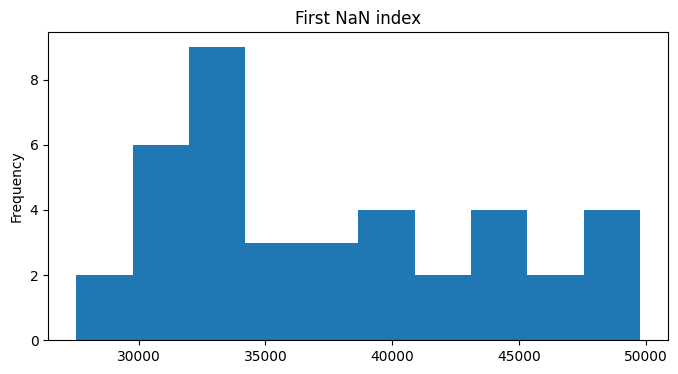

In [279]:
nan_count = np.isnan(df_data["lambdahat"]).value_counts()
print(nan_count)
if True in nan_count.index:
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    df_data["first_nan_index"].plot(kind="hist", ax=ax)
    ax.set_title("First NaN index");

In [280]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df_data["model_dim"], nbinsx=50))
fig.update_layout(
    title="Model Parameter Count", 
)

## $\lambda$ vs $\hat{\lambda}$

In [281]:
df = df_data
# df = df[df["true_rank"] < 2]
# df = df[df["true_multiplicity"] > 1]

s = 8
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df["true_lambda"], 
    y=df["lambdahat"], 
    mode='markers', 
    marker=dict(size=s),
    name='lambdahat'
))

fig.add_trace(go.Scatter(
    x=df["true_lambda"], 
    y=df["true_rank"], 
    mode='markers', 
    marker=dict(size=s),
    name='true_rank'
))

# fig.add_trace(go.Scatter(
#     x=df["true_lambda"], 
#     y=df["model_dim"] / 2, 
#     mode='markers', 
#     marker=dict(size=s, color='green'),
#     name='model dimension / 2'
# ))


fig.add_trace(go.Scatter(
    x=df["true_lambda"], 
    y=df["true_multiplicity"], 
    mode='markers', 
    marker=dict(size=s, color='purple'),
    name='multiplicity'
))

if "lambdahat_with_burnin" in df.columns:
    fig.add_trace(go.Scatter(
        x=df["true_lambda"], 
        y=df["lambdahat_with_burnin"], 
        mode='markers', 
        marker=dict(size=s),
        name='lambdahat_with_burnin'
    ))

# if "lambdahat_extrapolated_multiitemp" in df.columns:
#     fig.add_trace(go.Scatter(
#         x=df["true_lambda"], 
#         y=df["lambdahat_extrapolated_multiitemp"], 
#         mode='markers', 
#         marker=dict(size=s),
#         name='lambdahat_extrapolated_multiitemp'
#     ))


if "lambdahat_trained" in df.columns:
    fig.add_trace(go.Scatter(
        x=df["true_lambda"], 
        y=df["lambdahat_trained"], 
        mode='markers', 
        marker=dict(size=s),
        name='lambdahat_trained'
    ))

if "lambdahat_trained_with_burnin" in df.columns:
    fig.add_trace(go.Scatter(
        x=df["true_lambda"], 
        y=df["lambdahat_trained_with_burnin"], 
        mode='markers', 
        marker=dict(size=s),
        name='lambdahat_trained_with_burnin'
    ))


if "functional_rank" in df.columns:
    fig.add_trace(go.Scatter(
        x=df["true_lambda"], 
        y=df["functional_rank"] / 2, 
        mode='markers', 
        marker=dict(size=s),
        name='functional_rank / 2'
    ))


if "hessian_trace_estimate" in df.columns:
    fig.add_trace(go.Scatter(
        x=df["true_lambda"], 
        y=df["hessian_trace_estimate"], 
        mode='markers', 
        marker=dict(size=s),
        name='hessian_trace_estimate', 
        # yaxis="y2"
    ))

# Add the y=x line
sorted_true_lambda = sorted(df["true_lambda"])
fig.add_trace(go.Scatter(
    x=sorted_true_lambda, 
    y=sorted_true_lambda, 
    mode='lines', 
    line=dict(dash='dash', color='red', width=2),
    name='true_lambda'
))



fig.update_layout(
    title="Comparison of Metrics",
    xaxis_title="True lambda",
    yaxis_title="Metrics",
    legend_title="Legend",
    width=800,
    height=800,
    # xaxis_type="log", 
    # yaxis_type="log",
    yaxis=dict(
        title="Metric",
        side="left",
        showgrid=False,
        zeroline=False
    ),
    yaxis2=dict(
        title="Metric",
        side="right",
        overlaying="y",
        showgrid=False,
        zeroline=False
    ), 
)


# Save the figure as an image file
filepath = f'./outputs/images/{EXPT_NAME}_plot.html'
pio.write_html(fig, filepath)
# ! open $filepath
fig


In [282]:
df = df_data
s = 8
fig = go.Figure()


fig.add_trace(go.Scatter(
    x=df["true_lambda"], 
    y=df["lambdahat_with_burnin"], 
    mode='markers', 
    marker=dict(size=s),
    name='lambdahat_with_burnin'
))


if "lambdahat_trained_with_burnin" in df.columns:
    fig.add_trace(go.Scatter(
        x=df["true_lambda"], 
        y=df["lambdahat_trained_with_burnin"], 
        mode='markers', 
        marker=dict(size=s),
        name='lambdahat_trained_with_burnin'
    ))

# Add the y=x line
sorted_true_lambda = sorted(df["true_lambda"])
fig.add_trace(go.Scatter(
    x=sorted_true_lambda, 
    y=sorted_true_lambda, 
    mode='lines', 
    line=dict(dash='solid', color='blue', width=2),
    name='true_lambda'
))


fig.update_layout(
    # title="Comparison of Metrics",
    margin=dict(l=40, r=10, t=10, b=40),
    xaxis_title="True Learning Coefficient",
    yaxis_title="Estimated Local Learning Coefficient",
    legend=dict(
        x=0.4,
        y=0.98,
        bordercolor="Black",
        borderwidth=1,
        bgcolor='rgba(255,255,255,0.9)',  # slightly transparent white background
        xanchor='right',
        yanchor='top'
    ),
    width=800,
    height=800, 
    yaxis_type="log", 
    xaxis_type="log",
)



# Save the figure as an image file
config = sample_doc["config"]
truth_method = config["true_param_config"]["method"]
fileprefix = f"lambdahat_vs_lambda_{truth_method}_{EXPT_NAME}"
pio.write_html(fig, f'./outputs/images/{fileprefix}.html')
pio.write_image(fig, f"./outputs/images/{fileprefix}.png")
# ! open $filepath
fig


Text(0.5, 1.0, 'd=720.0-34537.0')

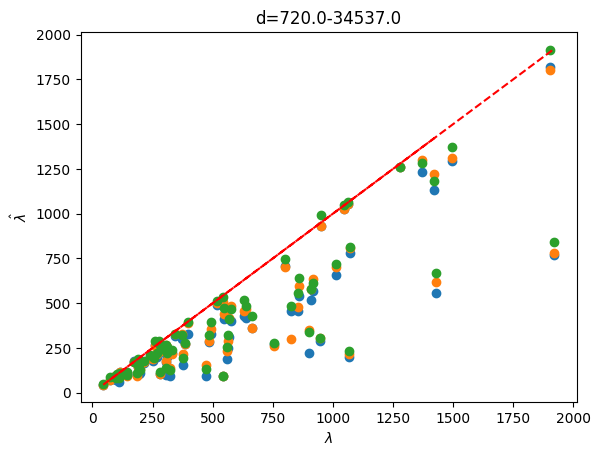

In [246]:
fig, ax = plt.subplots(1, 1)
ax.scatter(
    x=df["true_lambda"], 
    y=df["lambdahat"], 
)
ax.scatter(
    x=df["true_lambda"], 
    y=df["lambdahat_trained"], 
)

ax.scatter(
    x=df["true_lambda"], 
    y=df["lambdahat_with_burnin"], 
)
ax.plot(sorted_true_lambda, sorted_true_lambda, "r--")
ax.set_ylabel("$\hat{\lambda}$")
ax.set_xlabel("$\lambda$")
ax.set_title(f"d={df['model_dim'].min()}-{df['model_dim'].max()}")

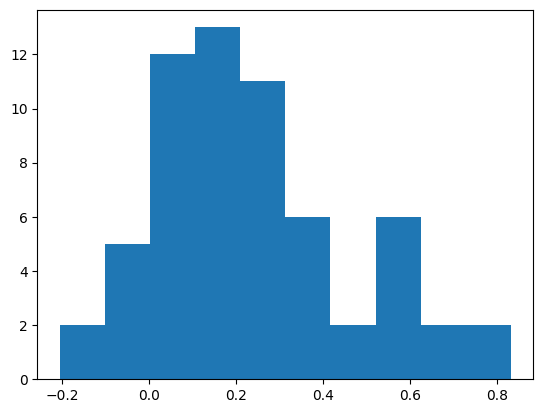

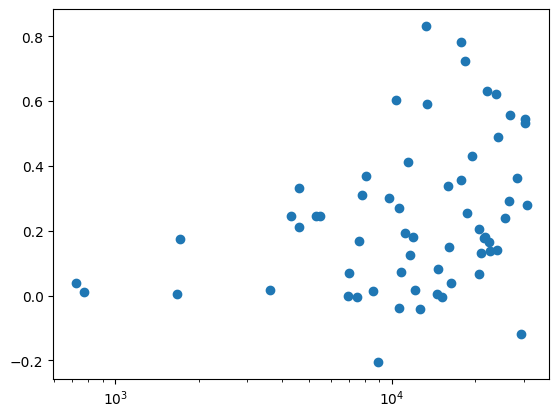

In [239]:
df = df_data
df["lambdahat_relative_error"] = (df["true_lambda"] - df["lambdahat_with_burnin"]) / df["true_lambda"]
fig, ax = plt.subplots()
ax.hist(df["lambdahat_relative_error"]);

fig, ax = plt.subplots()
ax.scatter(df["model_dim"], df["lambdahat_relative_error"])
ax.set_xscale("log")


In [247]:
df = df_data
fig = px.scatter(
    df, 
    x="true_lambda", 
    y="lambdahat_with_burnin", 
    # color="functional_rank",
    # color="true_multiplicity",
    # color="avg_width",
    color="model_dim",
    # color="num_layers",
    # size="num_layers",
    # size="true_rank",
    labels={
        "true_lambda": "True Learning Coefficient",
        "lambdahat": "Estimated Local Learning Coefficient",
        "model_dim": "Model Dimension",
        "num_layers": "Number of Layers",
        "true_rank": "True Rank"
    },
    # title="Scatter Plot of True Lambda vs Lambdahat"
)

# Add the y=x line
sorted_true_lambda = sorted(df["true_lambda"])
fig.add_trace(
    px.line(
        x=sorted_true_lambda, 
        y=sorted_true_lambda
    ).data[0]
)

# Update the layout
fig.update_layout(
    xaxis_title="True Learning Coefficient",
    yaxis_title="Estimated Local Learning Coefficient",
    legend_title="Legend",
    margin=dict(l=40, r=10, t=10, b=40),
    width=800,
    height=800, 
    yaxis_type="log", 
    xaxis_type="log",

)

fileprefix = f"lambdahat_vs_lambda_with_modeldim_{EXPT_NAME}"
pio.write_html(fig, f'./outputs/images/{fileprefix}.html')
pio.write_image(fig, f"./outputs/images/{fileprefix}.png")
# ! open $filepath
fig


## Loss trace

In [248]:
df = df_data
df = df[~np.isnan(df["lambdahat"])]
fig = go.Figure()

# index = 10
indices = np.random.randint(0, df.shape[0], size=10)
for index in indices: 
    sample_loss_trace = np.array(df.iloc[index]["loss_trace"])
    # print(df_data.iloc[index]["true_lambda"])
    n = df.iloc[index]["num_training_data"]
    # itemp = n / np.log(n)
    # distances = sample_doc["info"]["sgld_distances"]
    nsamples = len(sample_loss_trace)

    # Add trace for loss_trace
    fig.add_trace(
        go.Scatter(
            x=list(range(nsamples)),
            y=sample_loss_trace,
            name="Loss Trace",
            yaxis="y1"
        )
    )

# Add trace for distances
# fig.add_trace(
#     go.Scatter(
#         x=list(range(nsamples)),
#         y=distances,
#         name="Distances",
#         yaxis="y2"
#     )
# )

# Set layout for the graph
fig.update_layout(
    title="Loss Trace and Distances",
    xaxis_title="Sample Index",
    yaxis=dict(
        title="Loss Trace",
        side="left",
        showgrid=False,
        zeroline=False
    ),
    yaxis2=dict(
        title="Distances",
        side="right",
        overlaying="y",
        showgrid=False,
        zeroline=False
    )
)



## Effects of `sgld_config.num_steps`

In [1494]:
s = 500
burn_in = 0
sgld_num_steps = sample_doc["config"]["sgld_config"]["num_steps"]
n = sample_doc["config"]["num_training_data"]
data = []

# df = df_data[~np.isnan(df_data["lambdahat"])]
df = df_data

for i, row in df.iterrows():
    expt_id = row["_id"]
    trace = row["loss_trace"]
    init_loss = row["init_loss"]
    true_lambda = row["true_lambda"]
    for nstep in range(s + burn_in, sgld_num_steps + 1, s):
        nstep_lambdhat = (np.mean(trace[burn_in:nstep]) - init_loss) * n / np.log(n)
        data.append([expt_id, nstep, nstep_lambdhat, true_lambda])
df = pd.DataFrame(data, columns=["_id", "nstep", "lambdahat", "true_lambda"])

fig = px.scatter(
    df, 
    x="true_lambda", 
    y="lambdahat", 
    color="nstep",
    labels={
        "true_lambda": "True lambda",
        "lambdahat": "lambdahat",
        "nstep": "Num SGLD step"
    },
    title="True Lambda vs Lambdahat"
)

# Add the y=x line
sorted_true_lambda = sorted(df["true_lambda"])
fig.add_trace(
    px.line(
        x=sorted_true_lambda, 
        y=sorted_true_lambda
    ).data[0]
)

# Update the layout
fig.update_layout(
    xaxis_title="True lambda",
    yaxis_title="Lambdahat",
    legend_title="Legend",
    width=800,
    height=800, 
    # yaxis_type="log", 
    # xaxis_type="log",
)


# MALA acceptance

In [249]:
df = df_data
indices = np.random.randint(0, df.shape[0], size=5)
fig = go.Figure()

for index in indices:
    probs = np.array(df.iloc[index]["mala_acceptance_probs"])
    print(index, np.mean(probs[:, 1]))    
    fig.add_trace(
        go.Scatter(
            x=probs[:, 0], 
            y=probs[:, 1], 
            name=f"Index: {index}", 
        )
    )
fig

16 0.9534336605072021
24 0.9666444400548935
4 0.9676058905124665
40 0.9168978745937347
73 0.9776881421804429


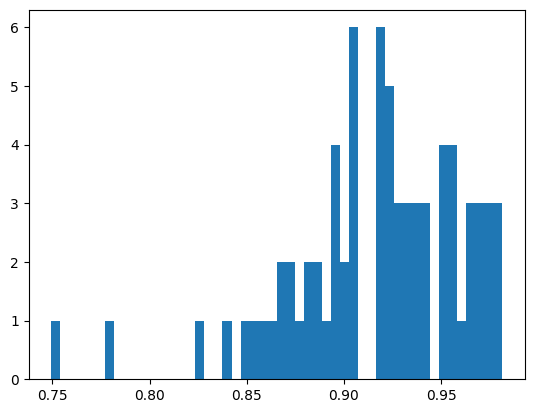

In [250]:
df = df_data
avg_acceptance_rates = []
for i, row in df.iterrows():
    rates = np.array(row["mala_acceptance_probs"])[:, 1]
    avg_acceptance_rates.append(np.mean(rates))
plt.hist(avg_acceptance_rates, bins=50);

## Functional rank

In [ ]:
df = df_data
# df = df[df["functional_rank"] / 2 > df["true_lambda"]]
row = df.iloc[0]
svdvals = row["svdvals"]
threshold = 0.005

print(np.sum(np.array(svdvals) > threshold) / 2, row["functional_rank"] / 2, row["true_lambda"])

fig = px.histogram(x=np.log10(svdvals), nbins=100)
fig.add_vline(x=np.log10(threshold))


TypeError: '>' not supported between instances of 'NoneType' and 'float'

# MISC

In [561]:
from scipy.special import logsumexp
from scipy.stats import linregress

def stable_weighted_average(Ls, n, delta_beta, factor=None):
    """
    Compute: 1/m \sum_{j = 1}^m n Ls[j] exp(- delta_beta * n * Ls[j])
    """
    m = len(Ls)
    Ls = np.array(Ls)
    log_terms = - delta_beta * n * Ls
    if factor is not None:
        log_terms += np.log(factor)
    average = np.exp(logsumexp(log_terms) - np.log(m))
    return average

def extrapolated_wbic(losses, n, itemp1, itemp2):
    delta_beta = itemp2 - itemp1
    numerator = stable_weighted_average(losses, n, delta_beta, factor=n * losses)
    normalisation = stable_weighted_average(losses, n, delta_beta)
    return numerator / normalisation
    
def extrapolated_multiitemp_lambdahat(losses, n, itemp_og, num_extrapolation=5, return_full=False):
    itemps = linspaced_itemps_by_n(n, num_extrapolation)
    wbics = [
        extrapolated_wbic(losses, n, itemp_og, itemp_new) for itemp_new in itemps
    ]
    result = linregress(1 / itemps, wbics)
    if return_full: 
        return result
    else:
        return result.slope


def linspaced_itemps_by_n(n, num_itemps):
    """
    Returns a 1D numpy array of length `num_itemps` that contains `num_itemps`
    evenly spaced inverse temperatures between the values calculated from the
    formula 1/log(n) * (1 - 1/sqrt(2log(n))) and 1/log(n) * (1 + 1/sqrt(2ln(n))).
    The formula is used in the context of simulating the behavior of a physical
    system at different temperatures using the Metropolis-Hastings algorithm.
    """
    return np.linspace(
        1 / np.log(n) * (1 - 1 / np.sqrt(2 * np.log(n))),
        1 / np.log(n) * (1 + 1 / np.sqrt(2 * np.log(n))),
        num_itemps,
    )

losses = np.array(sample_doc["info"]["loss_trace"])
n = sample_doc["config"]["num_training_data"]
itemp = sample_doc["config"]["itemp"]
itemp2 = 1.5 / np.log(n)
print(sample_doc["info"]["lambdahat"])
print(sample_doc["info"]["true_lambda"])
extrapolated_multiitemp_lambdahat(losses, n, itemp)

2.3827648162841797
17.5


5.749342293074781

LinregressResult(slope=3.542918809698694, intercept=7.219362117757711, rvalue=0.9978700036787324, pvalue=8.98220540679529e-11, stderr=0.08188705995913216, intercept_stderr=0.7805204940326309)

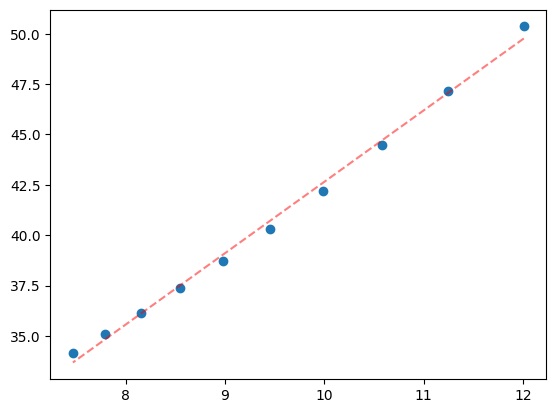

In [558]:
from scipy.stats import linregress

itemps = linspaced_itemps_by_n(n, 10)
losses = np.array(sample_doc["info"]["loss_trace"])[5000:]
n = sample_doc["config"]["num_training_data"]
itemp = sample_doc["config"]["itemp"]
wbics = [
    extrapolated_wbic(losses, n, itemp, itemp_new) for itemp_new in itemps
]
result = linregress(1/ itemps, wbics)

fig, ax = plt.subplots()
ax.scatter(1 / itemps, wbics)
ax.plot(1 / itemps, result.slope / itemps + result.intercept, "r--", alpha=0.5)
result

In [552]:
x = [1500, 1532, 2121, 1111, 1529, 1113, 1372, 1071, 1049, 2640, 2773, 2818, 2984, 1561, 2671, 2369]
sum([x[i -1] * x[i] for i in range(1, len(x))])

56892586

In [524]:
27 * n / np.log(n)

29314.877528469497

In [275]:
s = """outputs/slurm_logs/slurm_55492526_10.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492536.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_16.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492542.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_17.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492543.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_1.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492527.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_24.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492550.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_27.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492553.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_29.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492555.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_2.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492528.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_31.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492557.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_35.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492561.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_38.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492564.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_41.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492567.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_43.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492569.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_48.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492574.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_4.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492530.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_50.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492576.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_51.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492578.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_52.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492620.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_53.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492621.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_57.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492772.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_5.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492531.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_61.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492906.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_65.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492952.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_66.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492954.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_68.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492998.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_6.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55492532.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_72.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55493046.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_76.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55493139.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_77.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55493140.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_82.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55493189.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_83.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55493190.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_86.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55493236.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_87.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55493281.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_89.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55493327.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_90.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55493372.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_92.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55493375.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_93.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55493379.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_94.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55493381.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_96.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55493478.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_97.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55493480.batch. Some of the step tasks have been OOM Killed.
outputs/slurm_logs/slurm_55492526_99.err:slurmstepd: error: Detected 1 oom_kill event in StepId=55493483.batch. Some of the step tasks have been OOM Killed."""

import re
# Regular expression pattern to extract the numbers
pattern = r"slurm_\d+_(\d+)\.err"
num_list = [int(num) for num in re.findall(pattern, s)] + [100, 19, 32, 47, 71]
num_list = sorted(set(num_list))

print(len(num_list))
print(num_list)
def to_slurm_array_format(numbers):
    if not numbers:
        return ""

    # Initialize the first range
    ranges = [[numbers[0], numbers[0]]]

    # Build ranges
    for num in numbers[1:]:
        if num == ranges[-1][1] + 1:
            # Extend the current range
            ranges[-1][1] = num
        else:
            # Start a new range
            ranges.append([num, num])

    # Format ranges and single numbers
    return ",".join([f"{r[0]}-{r[1]}" if r[0] != r[1] else f"{r[0]}" for r in ranges])

slurm_array_str = to_slurm_array_format(num_list)
print(slurm_array_str)  # Use this in your SLURM script


46
[1, 2, 4, 5, 6, 10, 16, 17, 19, 24, 27, 29, 31, 32, 35, 38, 41, 43, 47, 48, 50, 51, 52, 53, 57, 61, 65, 66, 68, 71, 72, 76, 77, 82, 83, 86, 87, 89, 90, 92, 93, 94, 96, 97, 99, 100]
1-2,4-6,10,16-17,19,24,27,29,31-32,35,38,41,43,47-48,50-53,57,61,65-66,68,71-72,76-77,82-83,86-87,89-90,92-94,96-97,99-100
